In [ ]:
# importing the libraries
import random
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from keras.utils.np_utils import to_categorical
import torchvision
import torchvision.transforms as transforms
%matplotlib inline

In [ ]:
# mounting drive to access the dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
"""Upload the dataset in zip format to your drive"""

!unzip "/content/drive/MyDrive/archive.zip"

In [ ]:
# Removing the two outlier images from the dataset
# Resizing was an expensive operation so I just went ahead with this

import os 
for file in os.listdir("/content/Leather Defect Classification/Grain off"):
  img = cv2.imread(f"/content/Leather Defect Classification/Grain off/{file}")
  if img.shape == (3288, 4608, 3):
    print(file)
    os.remove(f"/content/Leather Defect Classification/Grain off/{file}")
    break
    
for file in os.listdir("/content/Leather Defect Classification/pinhole"):
  img = cv2.imread(f"/content/Leather Defect Classification/pinhole/{file}")
  if img.shape == (3288, 4608, 3):
    print(file)
    os.remove(f"/content/Leather Defect Classification/pinhole/{file}")
    break

Grain off 01 (327).jpg
Pinhole 01 (465).jpg


In [ ]:
# augmenting data with random mirroring of images and normalizing it
hflip = transforms.RandomHorizontalFlip(p=0.5)
train_transform = transforms.Compose([hflip, transforms.ToTensor(), transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

In [ ]:
# creating the dataset
dataset = torchvision.datasets.ImageFolder(root="/content/Leather Defect Classification", transform=train_transform)

In [ ]:
# dividing the dataset into train and test sets
train_dataset, test_dataset = random_split(dataset, lengths=[3300, 298])

In [ ]:
# the dataloaders with 2 worker processes each
train_loader = DataLoader(train_dataset, batch_size=32, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, num_workers=2)

In [ ]:
len(train_dataset), len(test_dataset)

(3300, 298)

In [ ]:
# selecting the GPU for training
device = torch.device("cuda:0")
device

device(type='cuda', index=0)

In [ ]:
class CNN_Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.convolutional_layers = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, stride=1),      # out size will be 6 x 225 x 225
        nn.ReLU(),
        nn.Conv2d(in_channels=6, out_channels=10, kernel_size=5, stride=1),     # out size will be 10 x 221 x 221
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),                                  # out size will be 10 x 110 x 110
        nn.Conv2d(in_channels=10, out_channels=10, kernel_size=1, stride=1),    # out size will be 10 x 110 x 110
        nn.Conv2d(in_channels=10, out_channels=25, kernel_size=3, stride=2),    # out size will be 25 x 54 x 54
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),                                  # out size will be 25 x 27 x 26
        nn.Conv2d(in_channels=25, out_channels=50, kernel_size=5, stride=2),    # out size will be 50 x 12 x 12
        nn.ReLU(),
        nn.Conv2d(in_channels=50, out_channels=100, kernel_size=3, stride=1),   # out size will be 100 x 10 x 10
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)                                   # out size will be 100 x 5 x 5
    )

    self.linear_layers = nn.Sequential(
        nn.Linear(2500, 500),
        nn.ReLU(),
        nn.Linear(500, 75),
        nn.ReLU(),
        nn.Linear(75, 6)
    )
    
    self.loss_fn = nn.CrossEntropyLoss(reduction="mean")                        # Loss function with mean reduction to prevent overflow
    self.optimizer = torch.optim.Adam(self.parameters(), lr=0.001)              # Adam optimizer with default hyperparameters
    self.train_loader = train_loader
    self.test_loader = test_loader
  
  def feed_forward(self, X):
    z = self.convolutional_layers(X)
    z_linear = z.reshape(z.shape[0], -1)
    out = self.linear_layers(z_linear)
    return out

  def backward(self, predictions, y):
    loss = self.loss_fn(predictions, y)
    loss.backward()
    self.optimizer.step()
    self.optimizer.zero_grad()

  def accuracy(self):
    count = 0
    total = 0
    for batch, target in self.test_loader:
      batch = batch.to(device)
      target = target.to(device)
      preds = self.feed_forward(batch)
      preds.to(device)
      correct_preds = torch.sum((torch.argmax(preds, axis=1) == target))
      count += correct_preds
      total += batch.shape[0]
    return count / total


  def fit(self, epochs):
    for i in range(epochs):
      for batch in self.train_loader:
        X, y = batch
        X = X.to(device)
        y = y.to(device)
        preds = self.feed_forward(X)
        preds.to(device)
        self.backward(preds, y)
      print(f"Accuracy at epoch {i+1}: {round(self.accuracy().item(), 4)}")


In [ ]:
# loading the trained model from drive for inferences
model = torch.load("/content/drive/MyDrive/trained_model.pth")
model

In [ ]:
model.fit(20)

Accuracy at epoch 1: 0.4291
Accuracy at epoch 2: 0.4497
Accuracy at epoch 3: 0.6167
Accuracy at epoch 4: 0.6036
Accuracy at epoch 5: 0.6015
Accuracy at epoch 6: 0.717
Accuracy at epoch 7: 0.76
Accuracy at epoch 8: 0.7515
Accuracy at epoch 9: 0.7694
Accuracy at epoch 10: 0.8418
Accuracy at epoch 11: 0.7324
Accuracy at epoch 12: 0.7515
Accuracy at epoch 13: 0.7103
Accuracy at epoch 14: 0.8245
Accuracy at epoch 15: 0.8097
Accuracy at epoch 16: 0.8294
Accuracy at epoch 17: 0.8136
Accuracy at epoch 18: 0.8521
Accuracy at epoch 19: 0.8442
Accuracy at epoch 20: 0.8706


In [ ]:
# helper functions
def forward_single_image(model, img):
    img = img.to(device)
    z = model.convolutional_layers(img)
    z_linear = z.reshape(1, -1)
    out = model.linear_layers(z_linear)
    return out

def convert(img):
  x = (img.cpu().numpy()*0.5 + 0.5) * 256
  x = np.moveaxis(x, 0, -1)
  return x.astype("uint8")

# the predict function
def predict(model, test_dataset):
  indices = [random.randint(0, len(test_dataset)) for _ in range(9)]
  fig, axes = plt.subplots(nrows=3, ncols=3)
  for i, axis in enumerate(axes.flat):
    img, label = test_dataset[indices[i]]
    img = img.to(device)
    pred = torch.argmax(forward_single_image(model, img))
    img = convert(img)
    axis.imshow(img)
    axis.set_title(f"Label:{label}, Prediction: {pred}")
  plt.tight_layout(True)


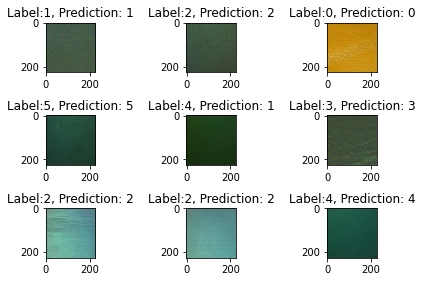

In [ ]:
predict(model, test_dataset)